<a href="https://colab.research.google.com/github/swilsonmfc/trees/blob/master/GradientBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Boosting

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier

# Algorithm

![](https://www.researchgate.net/publication/334973460/figure/fig4/AS:788765190660104@1565067684571/The-flow-of-gradient-boosting-algorithm.png)

# Algorithm Notes

## Step 1 - Build Model 0
* We typically initialize this to a constant
* We can probably agree that fitting a constant would be a high bias model
* From model 0, our squared error loss finds y_mean as the best constant

In [2]:
y = np.array([3, 6, 10, -4, 8])
guess_zero = [0] * 5
guess_mean = [np.mean(y)] * 5
print(f'Initialized at 0    : {mean_squared_error(y, guess_zero)}')
print(f'Initialized at Mean : {mean_squared_error(y, guess_mean)}')

Initialized at 0    : 45.0
Initialized at Mean : 23.84


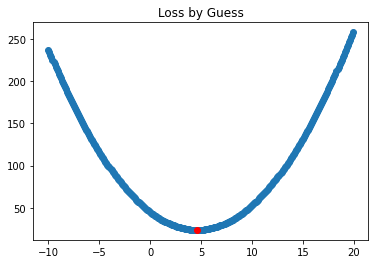

In [3]:
x, loss = [], []
for value in np.arange(-10, 20, 0.1):
  guess = [value] * 5
  x.append(value)
  loss.append(mean_squared_error(y, guess))
plt.scatter(x, loss)
plt.scatter(np.mean(y), mean_squared_error(y, guess_mean), color='red')
plt.title(f'Loss by Guess');

## Step 2 - Loop
* Loop for M number of iterations of boosting

## Step 3 : Pseudo Residuals
* For each observation compute the pseudo residual
  * Take the derivative of the loss comparing actual value vs prediction from last round of boosting
  * With respect to the derivative of the last round prediction

## Step 4 : Fit Weak Learner
* Fit a new weak (base) learner to the pseudo residuals of the training data from the last boosting round
* Think "find the best weak / base learner parameters" for this round

## Step 5 : Optimize
* Find the optimal value of lambda that minimizes the Loss from the prior round plus the "adjustment" of the weak learner in this rouund
* Remember gradient descent - We minimize loss by stepping in the direction of steepest descent
* Think "find the best weight to assign to this round's weak / base learner"

## Step 6: Update
* Similar to gradient descent's weight update
* We update the model with the optimized current round

# Visualization
* http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html
* Deeper trees - More non-linear
* Learning Rate - Faster to learn
* You most definitely can overfit

# Adaboost vs Gradient Boosting
* Based on boosting (improving) weak learners by placing more emphasis on hard to predict observations
* Formulation
  * Adaboost weights both observations and final aggregations
  * Uses the gradient of the loss with respect to the learner 
* Weighting / Misclassifications
  * Adaboost reweights observations (increasing weight on errors)
  * Finds problems looking at large residuals in last round
* Outliers 
  * Adaboost can be sensitive to outliers
  * Gradient boosting more robust

# Vanilla Gradient Boosting
* Digit classification
* Good for showing versitility of boosting

(1797, 64)


<Figure size 432x288 with 0 Axes>

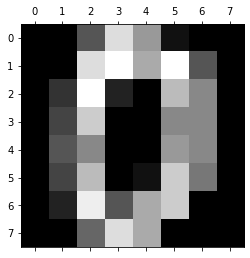

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
(1797, 64)

plt.gray() 
plt.matshow(digits.images[0]) 
plt.show() 

# Data

In [5]:
X = digits['data']
y = digits['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Model

In [7]:
%%time
model = GradientBoostingClassifier(n_estimators=500)
model.fit(X_train, y_train)

CPU times: user 14.5 s, sys: 22.1 ms, total: 14.5 s
Wall time: 14.6 s


# Test

In [8]:
pred = model.predict(X_test)
print(f'Accuracy {accuracy_score(y_test, pred):.4f}')
print(classification_report(y_test, pred))

Accuracy 0.9822
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.98      0.98      0.98        51
           2       1.00      0.98      0.99        45
           3       0.97      0.95      0.96        38
           4       1.00      1.00      1.00        52
           5       0.98      0.96      0.97        45
           6       1.00      1.00      1.00        46
           7       0.98      0.98      0.98        42
           8       0.98      0.98      0.98        46
           9       0.94      1.00      0.97        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



# Learning
* How can we evaluate the classifier's performance over rounds of boosting?

## Staged Predict Function
* We can run predict over each stage of boosting
* Use to evaluate learning over time with custom functions

In [20]:
%%time
clf = GradientBoostingClassifier(n_estimators=100, subsample=0.8)
clf.fit(X_train, y_train)

CPU times: user 7.59 s, sys: 8.76 ms, total: 7.6 s
Wall time: 7.62 s


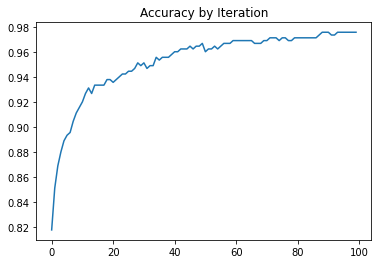

In [27]:
accuracy = []
for i, pred in enumerate(clf.staged_predict(X_test)):
  accuracy.append(accuracy_score(y_test, pred))
plt.plot(accuracy)
plt.title('Accuracy by Iteration');

## OOB Improvement
* We can look at the out of bag (unselected observation) improvement over each round of boosting
* Must use subsample < 1.0 to capture this information

In [18]:
%%time
clf = GradientBoostingClassifier(n_estimators=100, subsample=0.8)
clf.fit(X_train, y_train)

CPU times: user 7.53 s, sys: 7.51 ms, total: 7.54 s
Wall time: 7.54 s


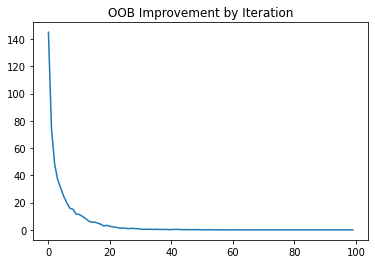

In [28]:
plt.plot(clf.oob_improvement_)
plt.title('OOB Improvement by Iteration');

## Staged Decision Function
* Run the test data through each stage of boosting
* Compute capture the loss error metric (in this case deviance)
* Plot for evaluating learning performance 

In [9]:
%%time
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train, y_train)

CPU times: user 8.88 s, sys: 11.4 ms, total: 8.89 s
Wall time: 8.91 s


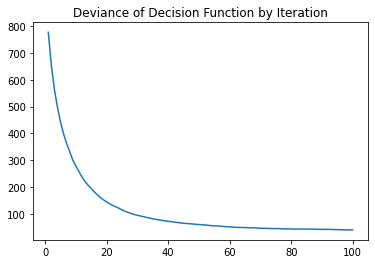

In [29]:
deviances = np.zeros(clf.n_estimators,)
for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    deviances[i] = clf.loss_(y_test, y_pred)
plt.plot((np.arange(deviances.shape[0]) + 1), deviances, '-')
plt.title('Deviance of Decision Function by Iteration');

# Early Stopping
* As the classifier stops making gains on the problem
* We can detect and exit from the learning process
* Saves compute time and can help prevent us from overfitting
* Use a validation data set (or portion of train set) to evaluate

In [11]:
%%time
model_es = GradientBoostingClassifier(n_estimators=500,
                                      validation_fraction=0.2,
                                      n_iter_no_change=5, 
                                      tol=0.01,
                                      random_state=0)
model_es.fit(X_train, y_train)

CPU times: user 8.04 s, sys: 13.8 ms, total: 8.06 s
Wall time: 8.08 s


In [12]:
pred = model_es.predict(X_test)
print(f'Accuracy {accuracy_score(y_test, pred):.4f}')
print(classification_report(y_test, pred))

Accuracy 0.9689
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        38
           1       0.98      0.96      0.97        51
           2       0.98      0.93      0.95        45
           3       0.95      0.95      0.95        38
           4       0.98      1.00      0.99        52
           5       0.98      0.93      0.95        45
           6       1.00      0.98      0.99        46
           7       0.98      0.98      0.98        42
           8       0.96      0.96      0.96        46
           9       0.94      1.00      0.97        47

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



In [13]:
model_es.n_estimators_

127

# Importances
* Gradient Boosting can tell us what features are most helpful

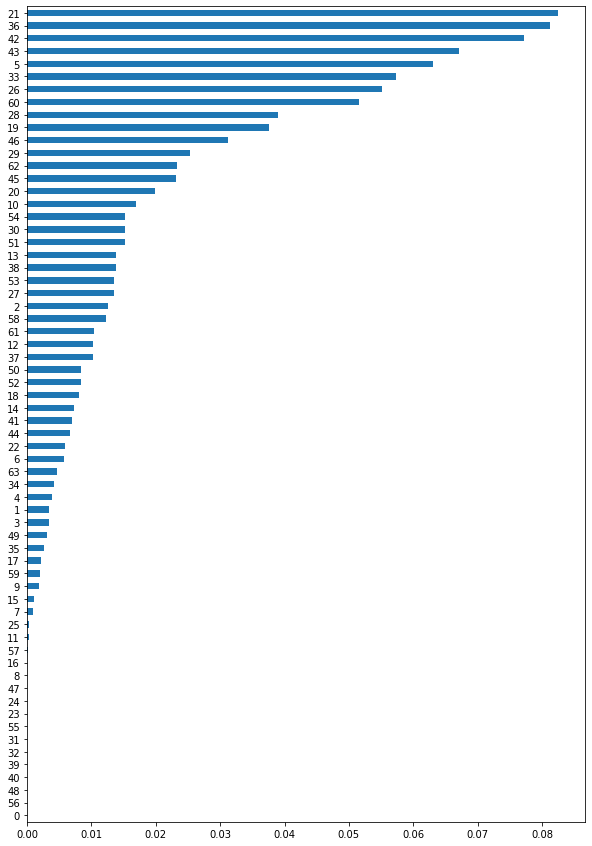

In [14]:
features = zip(np.arange(0, 64), model_es.feature_importances_)
feature_df = pd.DataFrame(features, columns=['Position', 'Importance']).sort_values('Importance')
feature_df['Importance'].plot.barh(figsize=(10, 15));

<Figure size 432x288 with 0 Axes>

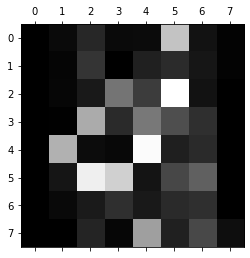

In [15]:
plt.gray() 
plt.matshow(model_es.feature_importances_.reshape(8, 8)) 
plt.show() 

# Hypertuning
* There are a large number of parameters available to Gradient Boosting
* Start with a high learning rate where converge in 50-100 trees
* Tune base learner parameters 
  * max_depth (in practice this is impactful)
  * min_samples_split
  * min_samples_leaf
  * subsample
* Reduce learning rate
  * Increase number of iterations
  * Alternatively, add early stopping


In [16]:
model = GradientBoostingClassifier(n_estimators=500,
                                   min_samples_split=15,
                                   min_samples_leaf=3,
                                   max_depth=8,
                                   subsample=0.8,
                                   validation_fraction=0.2,
                                   n_iter_no_change=5, 
                                   tol=0.01,
                                   random_state=0)
model_es.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.01,
                           validation_fraction=0.2, verbose=0,
                           warm_start=False)

In [17]:
pred = model_es.predict(X_test)
print(f'Accuracy {accuracy_score(y_test, pred):.4f}')
print(classification_report(y_test, pred))

Accuracy 0.9689
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        38
           1       0.98      0.96      0.97        51
           2       0.98      0.93      0.95        45
           3       0.95      0.95      0.95        38
           4       0.98      1.00      0.99        52
           5       0.98      0.93      0.95        45
           6       1.00      0.98      0.99        46
           7       0.98      0.98      0.98        42
           8       0.96      0.96      0.96        46
           9       0.94      1.00      0.97        47

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



# Overfitting
* Generally, boosting is somewhat resistant to overfitting
  * Early iterations focus on misclassified examples
  * Later iterations focus on classification margins (confidence)
* Boosting can overfit when 
  * Data is representative of the population
  * Noisy labels
  * Base learners are overly expressive
  * Too many iterations
* Fight overfitting by restricting the base learner
  * max Depth
  * min_samples_split
  * min_samples_leaf 

# Improvements
* Better generalization - Regularization
* Faster learning - Histogram building